# The Annotated Stable Diffusion 3.5

In [1]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F

import math

from diffusers.models.attention_processor import Attention
from diffusers.models.activations import GELU, GEGLU, ApproximateGELU, SwiGLU, LinearActivation

from diffusers.models.modeling_utils import ModelMixin

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.loaders import FromOriginalModelMixin, PeftAdapterMixin, SD3Transformer2DLoadersMixin
from diffusers.models.modeling_outputs import Transformer2DModelOutput

## Build Model

- Helper functions

In [2]:
class FP32LayerNorm(nn.LayerNorm):
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        origin_dtype = inputs.dtype
        return F.layer_norm(
            inputs.float(),
            self.normalized_shape,
            self.weight.float() if self.weight is not None else None,
            self.bias.float() if self.bias is not None else None,
            self.eps,
        ).to(origin_dtype)

def get_timestep_embedding(
    timesteps: torch.Tensor,
    embedding_dim: int,
    flip_sin_to_cos: bool = False,
    downscale_freq_shift: float = 1,
    scale: float = 1,
    max_period: int = 10000,
) -> torch.Tensor:
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models: Create sinusoidal timestep embeddings.

    Args
        timesteps (torch.Tensor):
            a 1-D Tensor of N indices, one per batch element. These may be fractional.
        embedding_dim (int):
            the dimension of the output.
        flip_sin_to_cos (bool):
            Whether the embedding order should be `cos, sin` (if True) or `sin, cos` (if False)
        downscale_freq_shift (float):
            Controls the delta between frequencies between dimensions
        scale (float):
            Scaling factor applied to the embeddings.
        max_period (int):
            Controls the maximum frequency of the embeddings
    Returns
        torch.Tensor: an [N x dim] Tensor of positional embeddings.
    """
    assert len(timesteps.shape) == 1, "Timesteps should be a 1d-array"

    half_dim = embedding_dim // 2
    exponent = -math.log(max_period) * torch.arange(
        start=0, end=half_dim, dtype=torch.float32, device=timesteps.device
    )
    exponent = exponent / (half_dim - downscale_freq_shift)

    emb = torch.exp(exponent)
    emb = timesteps[:, None].float() * emb[None, :]

    # scale embeddings
    emb = scale * emb

    # concat sine and cosine embeddings
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

    # flip sine and cosine embeddings
    if flip_sin_to_cos:
        emb = torch.cat([emb[:, half_dim:], emb[:, :half_dim]], dim=-1)

    # zero pad
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

ACT2CLS = {
    "swish": nn.SiLU,
    "silu": nn.SiLU,
    "mish": nn.Mish,
    "gelu": nn.GELU,
    "relu": nn.ReLU,
}

def get_activation(act_fn: str) -> nn.Module:
    """Helper function to get activation function from string.

    Args:
        act_fn (str): Name of activation function.

    Returns:
        nn.Module: Activation function.
    """

    act_fn = act_fn.lower()
    if act_fn in ACT2CLS:
        return ACT2CLS[act_fn]()
    else:
        raise ValueError(f"activation function {act_fn} not found in ACT2FN mapping {list(ACT2CLS.keys())}")

def get_2d_sincos_pos_embed(
    embed_dim,
    grid_size,
    cls_token=False,
    extra_tokens=0,
    interpolation_scale=1.0,
    base_size=16,
    device: Optional[torch.device] = None,
    output_type: str = "np",
):
    """
    Creates 2D sinusoidal positional embeddings.

    Args:
        embed_dim (`int`):
            The embedding dimension.
        grid_size (`int`):
            The size of the grid height and width.
        cls_token (`bool`, defaults to `False`):
            Whether or not to add a classification token.
        extra_tokens (`int`, defaults to `0`):
            The number of extra tokens to add.
        interpolation_scale (`float`, defaults to `1.0`):
            The scale of the interpolation.

    Returns:
        pos_embed (`torch.Tensor`):
            Shape is either `[grid_size * grid_size, embed_dim]` if not using cls_token, or `[1 + grid_size*grid_size,
            embed_dim]` if using cls_token
    """
    if output_type == "np":
        deprecation_message = (
            "`get_2d_sincos_pos_embed` uses `torch` and supports `device`."
            " `from_numpy` is no longer required."
            "  Pass `output_type='pt' to use the new version now."
        )
        deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
        return get_2d_sincos_pos_embed_np(
            embed_dim=embed_dim,
            grid_size=grid_size,
            cls_token=cls_token,
            extra_tokens=extra_tokens,
            interpolation_scale=interpolation_scale,
            base_size=base_size,
        )
    if isinstance(grid_size, int):
        grid_size = (grid_size, grid_size)

    grid_h = (
        torch.arange(grid_size[0], device=device, dtype=torch.float32)
        / (grid_size[0] / base_size)
        / interpolation_scale
    )
    grid_w = (
        torch.arange(grid_size[1], device=device, dtype=torch.float32)
        / (grid_size[1] / base_size)
        / interpolation_scale
    )
    grid = torch.meshgrid(grid_w, grid_h, indexing="xy")  # here w goes first
    grid = torch.stack(grid, dim=0)

    grid = grid.reshape([2, 1, grid_size[1], grid_size[0]])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid, output_type=output_type)
    if cls_token and extra_tokens > 0:
        pos_embed = torch.concat([torch.zeros([extra_tokens, embed_dim]), pos_embed], dim=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid, output_type="np"):
    r"""
    This function generates 2D sinusoidal positional embeddings from a grid.

    Args:
        embed_dim (`int`): The embedding dimension.
        grid (`torch.Tensor`): Grid of positions with shape `(H * W,)`.

    Returns:
        `torch.Tensor`: The 2D sinusoidal positional embeddings with shape `(H * W, embed_dim)`
    """
    if output_type == "np":
        deprecation_message = (
            "`get_2d_sincos_pos_embed_from_grid` uses `torch` and supports `device`."
            " `from_numpy` is no longer required."
            "  Pass `output_type='pt' to use the new version now."
        )
        deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
        return get_2d_sincos_pos_embed_from_grid_np(
            embed_dim=embed_dim,
            grid=grid,
        )
    if embed_dim % 2 != 0:
        raise ValueError("embed_dim must be divisible by 2")

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0], output_type=output_type)  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1], output_type=output_type)  # (H*W, D/2)

    emb = torch.concat([emb_h, emb_w], dim=1)  # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos, output_type="np", flip_sin_to_cos=False):
    """
    This function generates 1D positional embeddings from a grid.

    Args:
        embed_dim (`int`): The embedding dimension `D`
        pos (`torch.Tensor`): 1D tensor of positions with shape `(M,)`

    Returns:
        `torch.Tensor`: Sinusoidal positional embeddings of shape `(M, D)`.
    """
    if output_type == "np":
        deprecation_message = (
            "`get_1d_sincos_pos_embed_from_grid` uses `torch` and supports `device`."
            " `from_numpy` is no longer required."
            "  Pass `output_type='pt' to use the new version now."
        )
        deprecate("output_type=='np'", "0.34.0", deprecation_message, standard_warn=False)
        return get_1d_sincos_pos_embed_from_grid_np(embed_dim=embed_dim, pos=pos)
    if embed_dim % 2 != 0:
        raise ValueError("embed_dim must be divisible by 2")

    omega = torch.arange(embed_dim // 2, device=pos.device, dtype=torch.float64)
    omega /= embed_dim / 2.0
    omega = 1.0 / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = torch.outer(pos, omega)  # (M, D/2), outer product

    emb_sin = torch.sin(out)  # (M, D/2)
    emb_cos = torch.cos(out)  # (M, D/2)

    emb = torch.concat([emb_sin, emb_cos], dim=1)  # (M, D)

    # flip sine and cosine embeddings
    if flip_sin_to_cos:
        emb = torch.cat([emb[:, embed_dim // 2 :], emb[:, : embed_dim // 2]], dim=1)

    return emb

### Part I: basic components

The basic components of SD3.5 model includes:
- 

In [3]:
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding with support for SD3 cropping.

    Args:
        height (`int`, defaults to `224`): The height of the image.
        width (`int`, defaults to `224`): The width of the image.
        patch_size (`int`, defaults to `16`): The size of the patches.
        in_channels (`int`, defaults to `3`): The number of input channels.
        embed_dim (`int`, defaults to `768`): The output dimension of the embedding.
        layer_norm (`bool`, defaults to `False`): Whether or not to use layer normalization.
        flatten (`bool`, defaults to `True`): Whether or not to flatten the output.
        bias (`bool`, defaults to `True`): Whether or not to use bias.
        interpolation_scale (`float`, defaults to `1`): The scale of the interpolation.
        pos_embed_type (`str`, defaults to `"sincos"`): The type of positional embedding.
        pos_embed_max_size (`int`, defaults to `None`): The maximum size of the positional embedding.
    """

    def __init__(
        self,
        height=224,
        width=224,
        patch_size=16,
        in_channels=3,
        embed_dim=768,
        layer_norm=False,
        flatten=True,
        bias=True,
        interpolation_scale=1,
        pos_embed_type="sincos",
        pos_embed_max_size=None,  # For SD3 cropping
    ):
        super().__init__()

        num_patches = (height // patch_size) * (width // patch_size)
        self.flatten = flatten
        self.layer_norm = layer_norm
        self.pos_embed_max_size = pos_embed_max_size

        self.proj = nn.Conv2d(
            in_channels, embed_dim, kernel_size=(patch_size, patch_size), stride=patch_size, bias=bias
        )
        if layer_norm:
            self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False, eps=1e-6)
        else:
            self.norm = None

        self.patch_size = patch_size
        self.height, self.width = height // patch_size, width // patch_size
        self.base_size = height // patch_size
        self.interpolation_scale = interpolation_scale

        # Calculate positional embeddings based on max size or default
        if pos_embed_max_size:
            grid_size = pos_embed_max_size
        else:
            grid_size = int(num_patches**0.5)

        if pos_embed_type is None:
            self.pos_embed = None
        elif pos_embed_type == "sincos":
            pos_embed = get_2d_sincos_pos_embed(
                embed_dim,
                grid_size,
                base_size=self.base_size,
                interpolation_scale=self.interpolation_scale,
                output_type="pt",
            )
            persistent = True if pos_embed_max_size else False
            self.register_buffer("pos_embed", pos_embed.float().unsqueeze(0), persistent=persistent)
        else:
            raise ValueError(f"Unsupported pos_embed_type: {pos_embed_type}")

    def cropped_pos_embed(self, height, width):
        """Crops positional embeddings for SD3 compatibility."""
        if self.pos_embed_max_size is None:
            raise ValueError("`pos_embed_max_size` must be set for cropping.")

        height = height // self.patch_size
        width = width // self.patch_size
        if height > self.pos_embed_max_size:
            raise ValueError(
                f"Height ({height}) cannot be greater than `pos_embed_max_size`: {self.pos_embed_max_size}."
            )
        if width > self.pos_embed_max_size:
            raise ValueError(
                f"Width ({width}) cannot be greater than `pos_embed_max_size`: {self.pos_embed_max_size}."
            )

        top = (self.pos_embed_max_size - height) // 2
        left = (self.pos_embed_max_size - width) // 2
        spatial_pos_embed = self.pos_embed.reshape(1, self.pos_embed_max_size, self.pos_embed_max_size, -1)
        spatial_pos_embed = spatial_pos_embed[:, top : top + height, left : left + width, :]
        spatial_pos_embed = spatial_pos_embed.reshape(1, -1, spatial_pos_embed.shape[-1])
        return spatial_pos_embed

    def forward(self, latent):
        if self.pos_embed_max_size is not None:
            height, width = latent.shape[-2:]
        else:
            height, width = latent.shape[-2] // self.patch_size, latent.shape[-1] // self.patch_size
        latent = self.proj(latent)
        if self.flatten:
            latent = latent.flatten(2).transpose(1, 2)  # BCHW -> BNC
        if self.layer_norm:
            latent = self.norm(latent)
        if self.pos_embed is None:
            return latent.to(latent.dtype)
        # Interpolate or crop positional embeddings as needed
        if self.pos_embed_max_size:
            pos_embed = self.cropped_pos_embed(height, width)
        else:
            if self.height != height or self.width != width:
                pos_embed = get_2d_sincos_pos_embed(
                    embed_dim=self.pos_embed.shape[-1],
                    grid_size=(height, width),
                    base_size=self.base_size,
                    interpolation_scale=self.interpolation_scale,
                    device=latent.device,
                    output_type="pt",
                )
                pos_embed = pos_embed.float().unsqueeze(0)
            else:
                pos_embed = self.pos_embed

        return (latent + pos_embed).to(latent.dtype)

class PixArtAlphaTextProjection(nn.Module):
    """
    Projects caption embeddings. Also handles dropout for classifier-free guidance.

    Adapted from https://github.com/PixArt-alpha/PixArt-alpha/blob/master/diffusion/model/nets/PixArt_blocks.py
    """

    def __init__(self, in_features, hidden_size, out_features=None, act_fn="gelu_tanh"):
        super().__init__()
        if out_features is None:
            out_features = hidden_size
        self.linear_1 = nn.Linear(in_features=in_features, out_features=hidden_size, bias=True)
        if act_fn == "gelu_tanh":
            self.act_1 = nn.GELU(approximate="tanh")
        elif act_fn == "silu":
            self.act_1 = nn.SiLU()
        elif act_fn == "silu_fp32":
            self.act_1 = FP32SiLU()
        else:
            raise ValueError(f"Unknown activation function: {act_fn}")
        self.linear_2 = nn.Linear(in_features=hidden_size, out_features=out_features, bias=True)

    def forward(self, caption):
        hidden_states = self.linear_1(caption)
        hidden_states = self.act_1(hidden_states)
        hidden_states = self.linear_2(hidden_states)
        return hidden_states

In [4]:
class Timesteps(nn.Module):
    def __init__(self, num_channels: int, flip_sin_to_cos: bool, downscale_freq_shift: float, scale: int = 1):
        super().__init__()
        self.num_channels = num_channels
        self.flip_sin_to_cos = flip_sin_to_cos
        self.downscale_freq_shift = downscale_freq_shift
        self.scale = scale

    def forward(self, timesteps: torch.Tensor) -> torch.Tensor:
        t_emb = get_timestep_embedding(
            timesteps,
            self.num_channels,
            flip_sin_to_cos=self.flip_sin_to_cos,
            downscale_freq_shift=self.downscale_freq_shift,
            scale=self.scale,
        )
        return t_emb

class TimestepEmbedding(nn.Module):
    def __init__(
        self,
        in_channels: int,
        time_embed_dim: int,
        act_fn: str = "silu",
        out_dim: int = None,
        post_act_fn: Optional[str] = None,
        cond_proj_dim=None,
        sample_proj_bias=True,
    ):
        super().__init__()

        self.linear_1 = nn.Linear(in_channels, time_embed_dim, sample_proj_bias)

        if cond_proj_dim is not None:
            self.cond_proj = nn.Linear(cond_proj_dim, in_channels, bias=False)
        else:
            self.cond_proj = None

        self.act = get_activation(act_fn)

        if out_dim is not None:
            time_embed_dim_out = out_dim
        else:
            time_embed_dim_out = time_embed_dim
        self.linear_2 = nn.Linear(time_embed_dim, time_embed_dim_out, sample_proj_bias)

        if post_act_fn is None:
            self.post_act = None
        else:
            self.post_act = get_activation(post_act_fn)

    def forward(self, sample, condition=None):
        if condition is not None:
            sample = sample + self.cond_proj(condition)
        sample = self.linear_1(sample)

        if self.act is not None:
            sample = self.act(sample)

        sample = self.linear_2(sample)

        if self.post_act is not None:
            sample = self.post_act(sample)
        return sample

class LabelEmbedding(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.

    Args:
        num_classes (`int`): The number of classes.
        hidden_size (`int`): The size of the vector embeddings.
        dropout_prob (`float`): The probability of dropping a label.
    """

    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = torch.tensor(force_drop_ids == 1)
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels: torch.LongTensor, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (self.training and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings
    
class CombinedTimestepLabelEmbeddings(nn.Module):
    def __init__(self, num_classes, embedding_dim, class_dropout_prob=0.1):
        super().__init__()

        self.time_proj = Timesteps(num_channels=256, flip_sin_to_cos=True, downscale_freq_shift=1)
        self.timestep_embedder = TimestepEmbedding(in_channels=256, time_embed_dim=embedding_dim)
        self.class_embedder = LabelEmbedding(num_classes, embedding_dim, class_dropout_prob)

    def forward(self, timestep, class_labels, hidden_dtype=None):
        timesteps_proj = self.time_proj(timestep)
        timesteps_emb = self.timestep_embedder(timesteps_proj.to(dtype=hidden_dtype))  # (N, D)

        class_labels = self.class_embedder(class_labels)  # (N, D)

        conditioning = timesteps_emb + class_labels  # (N, D)

        return conditioning

class CombinedTimestepTextProjEmbeddings(nn.Module):
    def __init__(self, embedding_dim, pooled_projection_dim):
        super().__init__()

        self.time_proj = Timesteps(num_channels=256, flip_sin_to_cos=True, downscale_freq_shift=0)
        self.timestep_embedder = TimestepEmbedding(in_channels=256, time_embed_dim=embedding_dim)
        self.text_embedder = PixArtAlphaTextProjection(pooled_projection_dim, embedding_dim, act_fn="silu")

    def forward(self, timestep, pooled_projection):
        timesteps_proj = self.time_proj(timestep)
        timesteps_emb = self.timestep_embedder(timesteps_proj.to(dtype=pooled_projection.dtype))  # (N, D)

        pooled_projections = self.text_embedder(pooled_projection)

        conditioning = timesteps_emb + pooled_projections

        return conditioning

In [5]:
class FeedForward(nn.Module):
    r"""
    A feed-forward layer.

    Parameters:
        dim (`int`): The number of channels in the input.
        dim_out (`int`, *optional*): The number of channels in the output. If not given, defaults to `dim`.
        mult (`int`, *optional*, defaults to 4): The multiplier to use for the hidden dimension.
        dropout (`float`, *optional*, defaults to 0.0): The dropout probability to use.
        activation_fn (`str`, *optional*, defaults to `"geglu"`): Activation function to be used in feed-forward.
        final_dropout (`bool` *optional*, defaults to False): Apply a final dropout.
        bias (`bool`, defaults to True): Whether to use a bias in the linear layer.
    """

    def __init__(
        self,
        dim: int,
        dim_out: Optional[int] = None,
        mult: int = 4,
        dropout: float = 0.0,
        activation_fn: str = "geglu",
        final_dropout: bool = False,
        inner_dim=None,
        bias: bool = True,
    ):
        super().__init__()
        if inner_dim is None:
            inner_dim = int(dim * mult)
        dim_out = dim_out if dim_out is not None else dim

        if activation_fn == "gelu":
            act_fn = GELU(dim, inner_dim, bias=bias)
        if activation_fn == "gelu-approximate":
            act_fn = GELU(dim, inner_dim, approximate="tanh", bias=bias)
        elif activation_fn == "geglu":
            act_fn = GEGLU(dim, inner_dim, bias=bias)
        elif activation_fn == "geglu-approximate":
            act_fn = ApproximateGELU(dim, inner_dim, bias=bias)
        elif activation_fn == "swiglu":
            act_fn = SwiGLU(dim, inner_dim, bias=bias)
        elif activation_fn == "linear-silu":
            act_fn = LinearActivation(dim, inner_dim, bias=bias, activation="silu")

        self.net = nn.ModuleList([])
        # project in
        self.net.append(act_fn)
        # project dropout
        self.net.append(nn.Dropout(dropout))
        # project out
        self.net.append(nn.Linear(inner_dim, dim_out, bias=bias))
        # FF as used in Vision Transformer, MLP-Mixer, etc. have a final dropout
        if final_dropout:
            self.net.append(nn.Dropout(dropout))

    def forward(self, hidden_states: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)
        for module in self.net:
            hidden_states = module(hidden_states)
        return hidden_states

In [6]:
class RMSNorm(nn.Module):
    r"""
    RMS Norm as introduced in https://huggingface.co/papers/1910.07467 by Zhang et al.

    Args:
        dim (`int`): Number of dimensions to use for `weights`. Only effective when `elementwise_affine` is True.
        eps (`float`): Small value to use when calculating the reciprocal of the square-root.
        elementwise_affine (`bool`, defaults to `True`):
            Boolean flag to denote if affine transformation should be applied.
        bias (`bool`, defaults to False): If also training the `bias` param.
    """

    def __init__(self, dim, eps: float, elementwise_affine: bool = True, bias: bool = False):
        super().__init__()

        self.eps = eps
        self.elementwise_affine = elementwise_affine

        if isinstance(dim, numbers.Integral):
            dim = (dim,)

        self.dim = torch.Size(dim)

        self.weight = None
        self.bias = None

        if elementwise_affine:
            self.weight = nn.Parameter(torch.ones(dim))
            if bias:
                self.bias = nn.Parameter(torch.zeros(dim))

    def forward(self, hidden_states):
        if is_torch_npu_available():
            import torch_npu

            if self.weight is not None:
                # convert into half-precision if necessary
                if self.weight.dtype in [torch.float16, torch.bfloat16]:
                    hidden_states = hidden_states.to(self.weight.dtype)
            hidden_states = torch_npu.npu_rms_norm(hidden_states, self.weight, epsilon=self.eps)[0]
            if self.bias is not None:
                hidden_states = hidden_states + self.bias
        else:
            input_dtype = hidden_states.dtype
            variance = hidden_states.to(torch.float32).pow(2).mean(-1, keepdim=True)
            hidden_states = hidden_states * torch.rsqrt(variance + self.eps)

            if self.weight is not None:
                # convert into half-precision if necessary
                if self.weight.dtype in [torch.float16, torch.bfloat16]:
                    hidden_states = hidden_states.to(self.weight.dtype)
                hidden_states = hidden_states * self.weight
                if self.bias is not None:
                    hidden_states = hidden_states + self.bias
            else:
                hidden_states = hidden_states.to(input_dtype)

        return hidden_states
    
    
class AdaLayerNormZero(nn.Module):
    r"""
    Norm layer adaptive layer norm zero (adaLN-Zero).

    Parameters:
        embedding_dim (`int`): The size of each embedding vector.
        num_embeddings (`int`): The size of the embeddings dictionary.
    """

    def __init__(self, embedding_dim: int, num_embeddings: Optional[int] = None, norm_type="layer_norm", bias=True):
        super().__init__()
        if num_embeddings is not None:
            self.emb = CombinedTimestepLabelEmbeddings(num_embeddings, embedding_dim)
        else:
            self.emb = None

        self.silu = nn.SiLU()
        self.linear = nn.Linear(embedding_dim, 6 * embedding_dim, bias=bias)
        if norm_type == "layer_norm":
            self.norm = nn.LayerNorm(embedding_dim, elementwise_affine=False, eps=1e-6)
        elif norm_type == "fp32_layer_norm":
            self.norm = FP32LayerNorm(embedding_dim, elementwise_affine=False, bias=False)
        else:
            raise ValueError(
                f"Unsupported `norm_type` ({norm_type}) provided. Supported ones are: 'layer_norm', 'fp32_layer_norm'."
            )

    def forward(
        self,
        x: torch.Tensor,
        timestep: Optional[torch.Tensor] = None,
        class_labels: Optional[torch.LongTensor] = None,
        hidden_dtype: Optional[torch.dtype] = None,
        emb: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        if self.emb is not None:
            emb = self.emb(timestep, class_labels, hidden_dtype=hidden_dtype)
        emb = self.linear(self.silu(emb))
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = emb.chunk(6, dim=1)
        x = self.norm(x) * (1 + scale_msa[:, None]) + shift_msa[:, None]
        return x, gate_msa, shift_mlp, scale_mlp, gate_mlp

class AdaLayerNormContinuous(nn.Module):
    r"""
    Adaptive normalization layer with a norm layer (layer_norm or rms_norm).

    Args:
        embedding_dim (`int`): Embedding dimension to use during projection.
        conditioning_embedding_dim (`int`): Dimension of the input condition.
        elementwise_affine (`bool`, defaults to `True`):
            Boolean flag to denote if affine transformation should be applied.
        eps (`float`, defaults to 1e-5): Epsilon factor.
        bias (`bias`, defaults to `True`): Boolean flag to denote if bias should be use.
        norm_type (`str`, defaults to `"layer_norm"`):
            Normalization layer to use. Values supported: "layer_norm", "rms_norm".
    """

    def __init__(
        self,
        embedding_dim: int,
        conditioning_embedding_dim: int,
        # NOTE: It is a bit weird that the norm layer can be configured to have scale and shift parameters
        # because the output is immediately scaled and shifted by the projected conditioning embeddings.
        # Note that AdaLayerNorm does not let the norm layer have scale and shift parameters.
        # However, this is how it was implemented in the original code, and it's rather likely you should
        # set `elementwise_affine` to False.
        elementwise_affine=True,
        eps=1e-5,
        bias=True,
        norm_type="layer_norm",
    ):
        super().__init__()
        self.silu = nn.SiLU()
        self.linear = nn.Linear(conditioning_embedding_dim, embedding_dim * 2, bias=bias)
        if norm_type == "layer_norm":
            self.norm = nn.LayerNorm(embedding_dim, eps, elementwise_affine, bias)
        elif norm_type == "rms_norm":
            self.norm = RMSNorm(embedding_dim, eps, elementwise_affine)
        else:
            raise ValueError(f"unknown norm_type {norm_type}")

    def forward(self, x: torch.Tensor, conditioning_embedding: torch.Tensor) -> torch.Tensor:
        # convert back to the original dtype in case `conditioning_embedding`` is upcasted to float32 (needed for hunyuanDiT)
        emb = self.linear(self.silu(conditioning_embedding).to(x.dtype))
        scale, shift = torch.chunk(emb, 2, dim=1)
        x = self.norm(x) * (1 + scale)[:, None, :] + shift[:, None, :]
        return x

class SD35AdaLayerNormZeroX(nn.Module):
    r"""
    Norm layer adaptive layer norm zero (AdaLN-Zero).

    Parameters:
        embedding_dim (`int`): The size of each embedding vector.
        num_embeddings (`int`): The size of the embeddings dictionary.
    """

    def __init__(self, embedding_dim: int, norm_type: str = "layer_norm", bias: bool = True) -> None:
        super().__init__()

        self.silu = nn.SiLU()
        self.linear = nn.Linear(embedding_dim, 9 * embedding_dim, bias=bias)
        if norm_type == "layer_norm":
            self.norm = nn.LayerNorm(embedding_dim, elementwise_affine=False, eps=1e-6)
        else:
            raise ValueError(f"Unsupported `norm_type` ({norm_type}) provided. Supported ones are: 'layer_norm'.")

    def forward(
        self,
        hidden_states: torch.Tensor,
        emb: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, ...]:
        emb = self.linear(self.silu(emb))
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp, shift_msa2, scale_msa2, gate_msa2 = emb.chunk(
            9, dim=1
        )
        norm_hidden_states = self.norm(hidden_states)
        hidden_states = norm_hidden_states * (1 + scale_msa[:, None]) + shift_msa[:, None]
        norm_hidden_states2 = norm_hidden_states * (1 + scale_msa2[:, None]) + shift_msa2[:, None]
        return hidden_states, gate_msa, shift_mlp, scale_mlp, gate_mlp, norm_hidden_states2, gate_msa2

In [7]:
class JointAttnProcessor2_0:
    """Attention processor used typically in processing the SD3-like self-attention projections."""

    def __init__(self):
        if not hasattr(F, "scaled_dot_product_attention"):
            raise ImportError("JointAttnProcessor2_0 requires PyTorch 2.0, to use it, please upgrade PyTorch to 2.0.")

    def __call__(
        self,
        attn: Attention,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: torch.FloatTensor = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        *args,
        **kwargs,
    ) -> torch.FloatTensor:
        residual = hidden_states

        batch_size = hidden_states.shape[0]

        # `sample` projections.
        query = attn.to_q(hidden_states)
        key = attn.to_k(hidden_states)
        value = attn.to_v(hidden_states)

        inner_dim = key.shape[-1]
        head_dim = inner_dim // attn.heads

        query = query.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, attn.heads, head_dim).transpose(1, 2)

        if attn.norm_q is not None:
            query = attn.norm_q(query)
        if attn.norm_k is not None:
            key = attn.norm_k(key)

        # `context` projections.
        if encoder_hidden_states is not None:
            encoder_hidden_states_query_proj = attn.add_q_proj(encoder_hidden_states)
            encoder_hidden_states_key_proj = attn.add_k_proj(encoder_hidden_states)
            encoder_hidden_states_value_proj = attn.add_v_proj(encoder_hidden_states)

            encoder_hidden_states_query_proj = encoder_hidden_states_query_proj.view(
                batch_size, -1, attn.heads, head_dim
            ).transpose(1, 2)
            encoder_hidden_states_key_proj = encoder_hidden_states_key_proj.view(
                batch_size, -1, attn.heads, head_dim
            ).transpose(1, 2)
            encoder_hidden_states_value_proj = encoder_hidden_states_value_proj.view(
                batch_size, -1, attn.heads, head_dim
            ).transpose(1, 2)

            if attn.norm_added_q is not None:
                encoder_hidden_states_query_proj = attn.norm_added_q(encoder_hidden_states_query_proj)
            if attn.norm_added_k is not None:
                encoder_hidden_states_key_proj = attn.norm_added_k(encoder_hidden_states_key_proj)

            query = torch.cat([query, encoder_hidden_states_query_proj], dim=2)
            key = torch.cat([key, encoder_hidden_states_key_proj], dim=2)
            value = torch.cat([value, encoder_hidden_states_value_proj], dim=2)

        hidden_states = F.scaled_dot_product_attention(query, key, value, dropout_p=0.0, is_causal=False)
        hidden_states = hidden_states.transpose(1, 2).reshape(batch_size, -1, attn.heads * head_dim)
        hidden_states = hidden_states.to(query.dtype)

        if encoder_hidden_states is not None:
            # Split the attention outputs.
            hidden_states, encoder_hidden_states = (
                hidden_states[:, : residual.shape[1]],
                hidden_states[:, residual.shape[1] :],
            )
            if not attn.context_pre_only:
                encoder_hidden_states = attn.to_add_out(encoder_hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if encoder_hidden_states is not None:
            return hidden_states, encoder_hidden_states
        else:
            return hidden_states

### Part II: MM-DiT block

In [8]:
class JointTransformerBlock(nn.Module):
    r"""
    A Transformer block following the MMDiT architecture, introduced in Stable Diffusion 3.

    Reference: https://huggingface.co/papers/2403.03206

    Parameters:
        dim (`int`): The number of channels in the input and output.
        num_attention_heads (`int`): The number of heads to use for multi-head attention.
        attention_head_dim (`int`): The number of channels in each head.
        context_pre_only (`bool`): Boolean to determine if we should add some blocks associated with the
            processing of `context` conditions.
    """

    def __init__(
        self,
        dim: int,
        num_attention_heads: int,
        attention_head_dim: int,
        context_pre_only: bool = False,
        qk_norm: Optional[str] = None,
        use_dual_attention: bool = False,
    ):
        super().__init__()

        self.use_dual_attention = use_dual_attention
        self.context_pre_only = context_pre_only
        context_norm_type = "ada_norm_continous" if context_pre_only else "ada_norm_zero"

        if use_dual_attention:
            self.norm1 = SD35AdaLayerNormZeroX(dim)
        else:
            self.norm1 = AdaLayerNormZero(dim)

        if context_norm_type == "ada_norm_continous":
            self.norm1_context = AdaLayerNormContinuous(
                dim, dim, elementwise_affine=False, eps=1e-6, bias=True, norm_type="layer_norm"
            )
        elif context_norm_type == "ada_norm_zero":
            self.norm1_context = AdaLayerNormZero(dim)
        else:
            raise ValueError(
                f"Unknown context_norm_type: {context_norm_type}, currently only support `ada_norm_continous`, `ada_norm_zero`"
            )

        if hasattr(F, "scaled_dot_product_attention"):
            processor = JointAttnProcessor2_0()
        else:
            raise ValueError(
                "The current PyTorch version does not support the `scaled_dot_product_attention` function."
            )

        self.attn = Attention(
            query_dim=dim,
            cross_attention_dim=None,
            added_kv_proj_dim=dim,
            dim_head=attention_head_dim,
            heads=num_attention_heads,
            out_dim=dim,
            context_pre_only=context_pre_only,
            bias=True,
            processor=processor,
            qk_norm=qk_norm,
            eps=1e-6,
        )

        if use_dual_attention:
            self.attn2 = Attention(
                query_dim=dim,
                cross_attention_dim=None,
                dim_head=attention_head_dim,
                heads=num_attention_heads,
                out_dim=dim,
                bias=True,
                processor=processor,
                qk_norm=qk_norm,
                eps=1e-6,
            )
        else:
            self.attn2 = None

        self.norm2 = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
        self.ff = FeedForward(dim=dim, dim_out=dim, activation_fn="gelu-approximate")

        if not context_pre_only:
            self.norm2_context = nn.LayerNorm(dim, elementwise_affine=False, eps=1e-6)
            self.ff_context = FeedForward(dim=dim, dim_out=dim, activation_fn="gelu-approximate")
        else:
            self.norm2_context = None
            self.ff_context = None

        # let chunk size default to None
        self._chunk_size = None
        self._chunk_dim = 0

    # Copied from diffusers.models.attention.BasicTransformerBlock.set_chunk_feed_forward
    def set_chunk_feed_forward(self, chunk_size: Optional[int], dim: int = 0):
        # Sets chunk feed-forward
        self._chunk_size = chunk_size
        self._chunk_dim = dim

    def forward(
        self,
        hidden_states: torch.FloatTensor,
        encoder_hidden_states: torch.FloatTensor,
        temb: torch.FloatTensor,
        joint_attention_kwargs: Optional[Dict[str, Any]] = None,
    ):
        joint_attention_kwargs = joint_attention_kwargs or {}
        if self.use_dual_attention:
            norm_hidden_states, gate_msa, shift_mlp, scale_mlp, gate_mlp, norm_hidden_states2, gate_msa2 = self.norm1(
                hidden_states, emb=temb
            )
        else:
            norm_hidden_states, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.norm1(hidden_states, emb=temb)

        if self.context_pre_only:
            norm_encoder_hidden_states = self.norm1_context(encoder_hidden_states, temb)
        else:
            norm_encoder_hidden_states, c_gate_msa, c_shift_mlp, c_scale_mlp, c_gate_mlp = self.norm1_context(
                encoder_hidden_states, emb=temb
            )

        # Attention.
        attn_output, context_attn_output = self.attn(
            hidden_states=norm_hidden_states,
            encoder_hidden_states=norm_encoder_hidden_states,
            **joint_attention_kwargs,
        )

        # Process attention outputs for the `hidden_states`.
        attn_output = gate_msa.unsqueeze(1) * attn_output
        hidden_states = hidden_states + attn_output

        if self.use_dual_attention:
            attn_output2 = self.attn2(hidden_states=norm_hidden_states2, **joint_attention_kwargs)
            attn_output2 = gate_msa2.unsqueeze(1) * attn_output2
            hidden_states = hidden_states + attn_output2

        norm_hidden_states = self.norm2(hidden_states)
        norm_hidden_states = norm_hidden_states * (1 + scale_mlp[:, None]) + shift_mlp[:, None]
        if self._chunk_size is not None:
            # "feed_forward_chunk_size" can be used to save memory
            ff_output = _chunked_feed_forward(self.ff, norm_hidden_states, self._chunk_dim, self._chunk_size)
        else:
            ff_output = self.ff(norm_hidden_states)
        ff_output = gate_mlp.unsqueeze(1) * ff_output

        hidden_states = hidden_states + ff_output

        # Process attention outputs for the `encoder_hidden_states`.
        if self.context_pre_only:
            encoder_hidden_states = None
        else:
            context_attn_output = c_gate_msa.unsqueeze(1) * context_attn_output
            encoder_hidden_states = encoder_hidden_states + context_attn_output

            norm_encoder_hidden_states = self.norm2_context(encoder_hidden_states)
            norm_encoder_hidden_states = norm_encoder_hidden_states * (1 + c_scale_mlp[:, None]) + c_shift_mlp[:, None]
            if self._chunk_size is not None:
                # "feed_forward_chunk_size" can be used to save memory
                context_ff_output = _chunked_feed_forward(
                    self.ff_context, norm_encoder_hidden_states, self._chunk_dim, self._chunk_size
                )
            else:
                context_ff_output = self.ff_context(norm_encoder_hidden_states)
            encoder_hidden_states = encoder_hidden_states + c_gate_mlp.unsqueeze(1) * context_ff_output

        return encoder_hidden_states, hidden_states

### Part III: SD 3.5 model

In [9]:
class SD3Transformer2DModel(
    ModelMixin, ConfigMixin, PeftAdapterMixin, FromOriginalModelMixin, SD3Transformer2DLoadersMixin
):
    """
    The Transformer model introduced in [Stable Diffusion 3](https://huggingface.co/papers/2403.03206).

    Parameters:
        sample_size (`int`, defaults to `128`):
            The width/height of the latents. This is fixed during training since it is used to learn a number of
            position embeddings.
        patch_size (`int`, defaults to `2`):
            Patch size to turn the input data into small patches.
        in_channels (`int`, defaults to `16`):
            The number of latent channels in the input.
        num_layers (`int`, defaults to `18`):
            The number of layers of transformer blocks to use.
        attention_head_dim (`int`, defaults to `64`):
            The number of channels in each head.
        num_attention_heads (`int`, defaults to `18`):
            The number of heads to use for multi-head attention.
        joint_attention_dim (`int`, defaults to `4096`):
            The embedding dimension to use for joint text-image attention.
        caption_projection_dim (`int`, defaults to `1152`):
            The embedding dimension of caption embeddings.
        pooled_projection_dim (`int`, defaults to `2048`):
            The embedding dimension of pooled text projections.
        out_channels (`int`, defaults to `16`):
            The number of latent channels in the output.
        pos_embed_max_size (`int`, defaults to `96`):
            The maximum latent height/width of positional embeddings.
        dual_attention_layers (`Tuple[int, ...]`, defaults to `()`):
            The number of dual-stream transformer blocks to use.
        qk_norm (`str`, *optional*, defaults to `None`):
            The normalization to use for query and key in the attention layer. If `None`, no normalization is used.
    """

    _supports_gradient_checkpointing = True
    _no_split_modules = ["JointTransformerBlock"]
    _skip_layerwise_casting_patterns = ["pos_embed", "norm"]

    @register_to_config
    def __init__(
        self,
        sample_size: int = 128,
        patch_size: int = 2,
        in_channels: int = 16,
        num_layers: int = 18,
        attention_head_dim: int = 64,
        num_attention_heads: int = 18,
        joint_attention_dim: int = 4096,
        caption_projection_dim: int = 1152,
        pooled_projection_dim: int = 2048,
        out_channels: int = 16,
        pos_embed_max_size: int = 96,
        dual_attention_layers: Tuple[
            int, ...
        ] = (),  # () for sd3.0; (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12) for sd3.5
        qk_norm: Optional[str] = None,
    ):
        super().__init__()
        self.out_channels = out_channels if out_channels is not None else in_channels
        self.inner_dim = num_attention_heads * attention_head_dim

        self.pos_embed = PatchEmbed(
            height=sample_size,
            width=sample_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=self.inner_dim,
            pos_embed_max_size=pos_embed_max_size,  # hard-code for now.
        )
        self.time_text_embed = CombinedTimestepTextProjEmbeddings(
            embedding_dim=self.inner_dim, pooled_projection_dim=pooled_projection_dim
        )
        self.context_embedder = nn.Linear(joint_attention_dim, caption_projection_dim)

        self.transformer_blocks = nn.ModuleList(
            [
                JointTransformerBlock(
                    dim=self.inner_dim,
                    num_attention_heads=num_attention_heads,
                    attention_head_dim=attention_head_dim,
                    context_pre_only=i == num_layers - 1,
                    qk_norm=qk_norm,
                    use_dual_attention=True if i in dual_attention_layers else False,
                )
                for i in range(num_layers)
            ]
        )

        self.norm_out = AdaLayerNormContinuous(self.inner_dim, self.inner_dim, elementwise_affine=False, eps=1e-6)
        self.proj_out = nn.Linear(self.inner_dim, patch_size * patch_size * self.out_channels, bias=True)

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        encoder_hidden_states: torch.Tensor = None,
        pooled_projections: torch.Tensor = None,
        timestep: torch.LongTensor = None,
        block_controlnet_hidden_states: List = None,
        joint_attention_kwargs: Optional[Dict[str, Any]] = None,
        return_dict: bool = True,
        skip_layers: Optional[List[int]] = None,
    ) -> Union[torch.Tensor, Transformer2DModelOutput]:
        """
        The [`SD3Transformer2DModel`] forward method.

        Args:
            hidden_states (`torch.Tensor` of shape `(batch size, channel, height, width)`):
                Input `hidden_states`.
            encoder_hidden_states (`torch.Tensor` of shape `(batch size, sequence_len, embed_dims)`):
                Conditional embeddings (embeddings computed from the input conditions such as prompts) to use.
            pooled_projections (`torch.Tensor` of shape `(batch_size, projection_dim)`):
                Embeddings projected from the embeddings of input conditions.
            timestep (`torch.LongTensor`):
                Used to indicate denoising step.
            block_controlnet_hidden_states (`list` of `torch.Tensor`):
                A list of tensors that if specified are added to the residuals of transformer blocks.
            joint_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~models.transformer_2d.Transformer2DModelOutput`] instead of a plain
                tuple.
            skip_layers (`list` of `int`, *optional*):
                A list of layer indices to skip during the forward pass.

        Returns:
            If `return_dict` is True, an [`~models.transformer_2d.Transformer2DModelOutput`] is returned, otherwise a
            `tuple` where the first element is the sample tensor.
        """
        if joint_attention_kwargs is not None:
            joint_attention_kwargs = joint_attention_kwargs.copy()
            lora_scale = joint_attention_kwargs.pop("scale", 1.0)
        else:
            lora_scale = 1.0


        height, width = hidden_states.shape[-2:]

        hidden_states = self.pos_embed(hidden_states)  # takes care of adding positional embeddings too.
        temb = self.time_text_embed(timestep, pooled_projections)
        encoder_hidden_states = self.context_embedder(encoder_hidden_states)

        if joint_attention_kwargs is not None and "ip_adapter_image_embeds" in joint_attention_kwargs:
            ip_adapter_image_embeds = joint_attention_kwargs.pop("ip_adapter_image_embeds")
            ip_hidden_states, ip_temb = self.image_proj(ip_adapter_image_embeds, timestep)

            joint_attention_kwargs.update(ip_hidden_states=ip_hidden_states, temb=ip_temb)

        for index_block, block in enumerate(self.transformer_blocks):
            # Skip specified layers
            is_skip = True if skip_layers is not None and index_block in skip_layers else False

            if torch.is_grad_enabled() and self.gradient_checkpointing and not is_skip:
                encoder_hidden_states, hidden_states = self._gradient_checkpointing_func(
                    block,
                    hidden_states,
                    encoder_hidden_states,
                    temb,
                    joint_attention_kwargs,
                )
            elif not is_skip:
                encoder_hidden_states, hidden_states = block(
                    hidden_states=hidden_states,
                    encoder_hidden_states=encoder_hidden_states,
                    temb=temb,
                    joint_attention_kwargs=joint_attention_kwargs,
                )

            # controlnet residual
            if block_controlnet_hidden_states is not None and block.context_pre_only is False:
                interval_control = len(self.transformer_blocks) / len(block_controlnet_hidden_states)
                hidden_states = hidden_states + block_controlnet_hidden_states[int(index_block / interval_control)]

        hidden_states = self.norm_out(hidden_states, temb)
        hidden_states = self.proj_out(hidden_states)

        # unpatchify
        patch_size = self.config.patch_size
        height = height // patch_size
        width = width // patch_size

        hidden_states = hidden_states.reshape(
            shape=(hidden_states.shape[0], height, width, patch_size, patch_size, self.out_channels)
        )
        hidden_states = torch.einsum("nhwpqc->nchpwq", hidden_states)
        output = hidden_states.reshape(
            shape=(hidden_states.shape[0], self.out_channels, height * patch_size, width * patch_size)
        )

        if not return_dict:
            return (output,)

        return Transformer2DModelOutput(sample=output)

- Load model

In [10]:
transformer = SD3Transformer2DModel.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.float16, subfolder="transformer")
transformer.to("cuda")

SD3Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(16, 1536, kernel_size=(2, 2), stride=(2, 2))
  )
  (time_text_embed): CombinedTimestepTextProjEmbeddings(
    (time_proj): Timesteps()
    (timestep_embedder): TimestepEmbedding(
      (linear_1): Linear(in_features=256, out_features=1536, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=1536, out_features=1536, bias=True)
    )
    (text_embedder): PixArtAlphaTextProjection(
      (linear_1): Linear(in_features=2048, out_features=1536, bias=True)
      (act_1): SiLU()
      (linear_2): Linear(in_features=1536, out_features=1536, bias=True)
    )
  )
  (context_embedder): Linear(in_features=4096, out_features=1536, bias=True)
  (transformer_blocks): ModuleList(
    (0-12): 13 x JointTransformerBlock(
      (norm1): SD35AdaLayerNormZeroX(
        (silu): SiLU()
        (linear): Linear(in_features=1536, out_features=13824, bias=True)
        (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=Fa

## Inference Pipeline

- Define hyperparameters and inputs

In [11]:
# hyperparameters
device = "cuda"
batch_size = 1
dtype = torch.float16
height = 1024
width = 1024
num_inference_steps = 50

# inputs
prompt = "A beautiful landscape with mountains and a river"

- Load vae and pretrained language models

In [12]:
from diffusers import AutoencoderKL
from transformers import CLIPTextModelWithProjection,T5EncoderModel,AutoTokenizer

vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=dtype, subfolder="vae", device=device)

text_encoder_one = CLIPTextModelWithProjection.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="text_encoder", torch_dtype=dtype)
text_encoder_two = CLIPTextModelWithProjection.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="text_encoder_2", torch_dtype=dtype)
text_encoder_three = T5EncoderModel.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="text_encoder_3", torch_dtype=dtype)

tokenizer_one = AutoTokenizer.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="tokenizer", use_fast=False, torch_dtype=dtype, device=device)
tokenizer_two = AutoTokenizer.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="tokenizer_2", use_fast=False, torch_dtype=dtype, device=device)
tokenizer_three = AutoTokenizer.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="tokenizer_3", use_fast=False, torch_dtype=dtype, device=device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

- Encode prompt

In [13]:
def _encode_prompt_with_t5(
    text_encoder,
    tokenizer,
    max_sequence_length,
    prompt=None,
    text_input_ids=None,
    num_images_per_prompt=1,
    device=None,
):
    prompt = [prompt] if isinstance(prompt, str) else prompt
    if prompt is not None:
        batch_size = len(prompt)
    else:
        batch_size = text_input_ids.shape[0]

    if tokenizer is not None:
        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=max_sequence_length,
            truncation=True,
            add_special_tokens=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
    else:
        if text_input_ids is None:
            raise ValueError("text_input_ids must be provided when the tokenizer is not specified")
    prompt_embeds = text_encoder(text_input_ids.to(device))[0]

    dtype = text_encoder.dtype
    prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

    _, seq_len, _ = prompt_embeds.shape

    # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

    return prompt_embeds

def _encode_prompt_with_clip(
    text_encoder,
    tokenizer,
    prompt: str,
    device=None,
    text_input_ids=None,
    num_images_per_prompt: int = 1,
):
    prompt = [prompt] if isinstance(prompt, str) else prompt
    if prompt is not None:
        batch_size = len(prompt)
    else:
        batch_size = text_input_ids.shape[0]

    if tokenizer is not None:
        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=77,
            truncation=True,
            return_tensors="pt",
        )

        text_input_ids = text_inputs.input_ids
    else:
        if text_input_ids is None:
            raise ValueError("text_input_ids must be provided when the tokenizer is not specified")

    prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)

    pooled_prompt_embeds = prompt_embeds[0]
    prompt_embeds = prompt_embeds.hidden_states[-2]
    prompt_embeds = prompt_embeds.to(dtype=text_encoder.dtype, device=device)

    _, seq_len, _ = prompt_embeds.shape
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

    return prompt_embeds, pooled_prompt_embeds

In [14]:
prompt_embed, pooled_prompt_embed = _encode_prompt_with_clip(
    text_encoder=text_encoder_one,
    tokenizer=tokenizer_one,
    prompt=prompt,
    device=text_encoder_one.device,
)
prompt_2_embed, pooled_prompt_2_embed = _encode_prompt_with_clip(
    text_encoder=text_encoder_two,
    tokenizer=tokenizer_two,
    prompt=prompt,
    device=text_encoder_two.device,
)
clip_prompt_embeds = torch.cat([prompt_embed, prompt_2_embed], dim=-1)

t5_prompt_embed = _encode_prompt_with_t5(
    text_encoder=text_encoder_three,
    tokenizer=tokenizer_three,
    prompt=prompt,
    device=text_encoder_three.device,
    max_sequence_length=77,
)

clip_prompt_embeds = torch.nn.functional.pad(
    clip_prompt_embeds, (0, t5_prompt_embed.shape[-1] - clip_prompt_embeds.shape[-1])
)

prompt_embeds = torch.cat([clip_prompt_embeds, t5_prompt_embed], dim=-2).to(dtype=torch.float16, device=device)
pooled_prompt_embeds = torch.cat([pooled_prompt_embed, pooled_prompt_2_embed], dim=-1).to(dtype=torch.float16, device=device)

- Prepare latents

In [15]:
from diffusers.utils.torch_utils import randn_tensor

num_channels_latents = transformer.config.in_channels
vae_scale_factor = 2 ** (len(vae.config.block_out_channels) - 1)
print(f"VAE scale factor: {vae_scale_factor}")

shape = (batch_size, num_channels_latents, int(height) // vae_scale_factor, int(width) // vae_scale_factor)

latents = randn_tensor(shape, device=device, dtype=dtype)

VAE scale factor: 8


- Prepare timesteps

In [16]:
from diffusers import FlowMatchEulerDiscreteScheduler
noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-3.5-medium", subfolder="scheduler")
print(noise_scheduler.config.get("use_dynamic_shifting", None))

False


In [17]:
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    r"""
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps

In [18]:
timesteps, num_inference_steps = retrieve_timesteps(
    noise_scheduler,
    num_inference_steps,
    device,
)
num_warmup_steps = max(len(timesteps) - num_inference_steps * noise_scheduler.order, 0)


- Denoising loop

In [19]:
with torch.no_grad(): 
    for i, t in enumerate(timesteps):
        latent_model_input = latents
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timestep = t.expand(latent_model_input.shape[0])

        noise_pred = transformer(
            hidden_states=latent_model_input,
            timestep=timestep,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
            return_dict=False,
        )[0]

        # TODO we can add guidance later

        # compute the previous noisy sample x_t -> x_t-1
        latents_dtype = latents.dtype
        latents = noise_scheduler.step(noise_pred, t, latents, return_dict=False)[0]



- Turn latents into images

In [20]:
latents = (latents / vae.config.scaling_factor) + vae.config.shift_factor

vae.to(device)

image = vae.decode(latents, return_dict=False)[0]

from diffusers.image_processor import VaeImageProcessor

image_processor = VaeImageProcessor(vae_scale_factor=vae_scale_factor)
image = image_processor.postprocess(image.detach(), output_type="pil")[0]

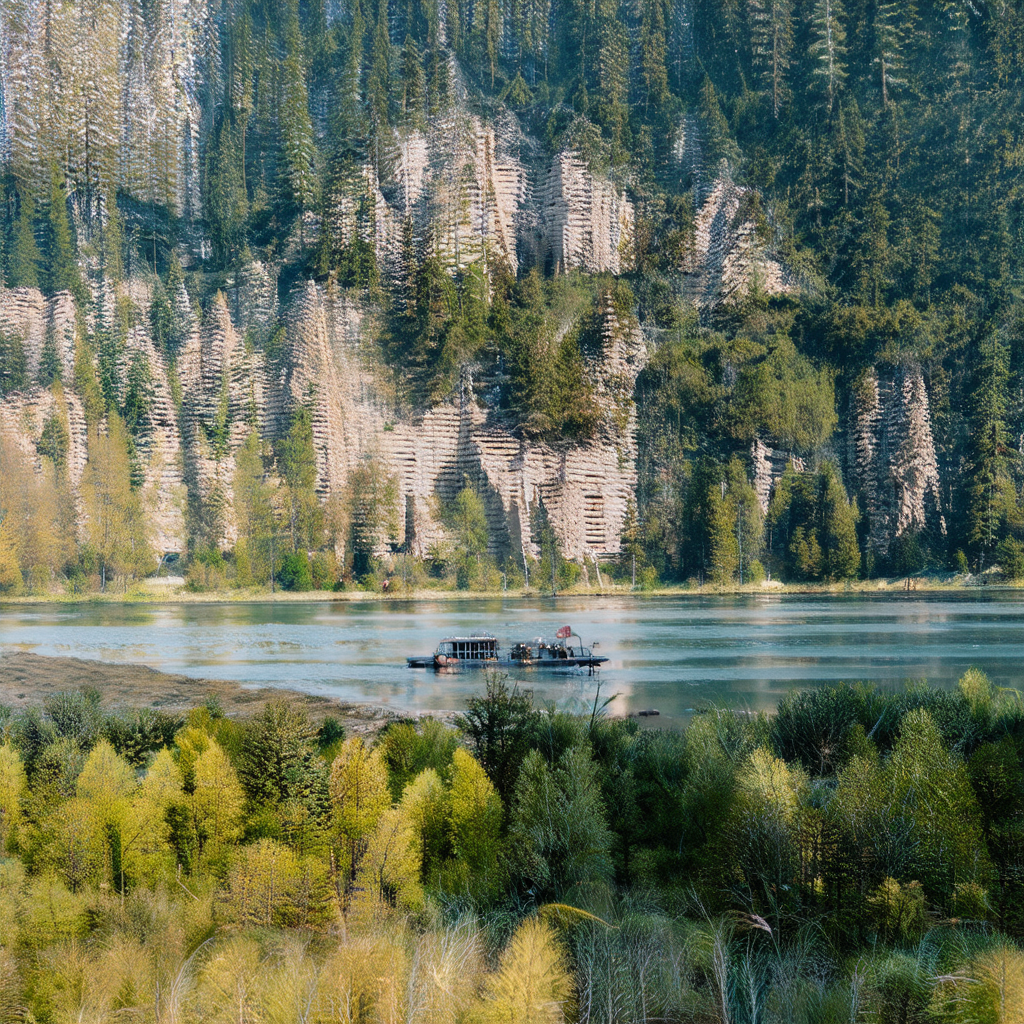

In [21]:
from IPython.display import display
display(image)